# Visão Computacional -  GANs

- Adaptado de: https://www.tensorflow.org/beta/tutorials/generative/dcgan

# Importação das bibliotecas

In [22]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.8.0'

# Carregamento e pré-processamento da base de dados

In [23]:
(X_treinamento, y_treinamento), (_,_) = tf.keras.datasets.mnist.load_data()

X_treinamento = X_treinamento[(y_treinamento==7)]
y_treinamento = y_treinamento[(y_treinamento==7)]



11501568/11490434 [==============================] - 0s 0us/step


Numero: 7


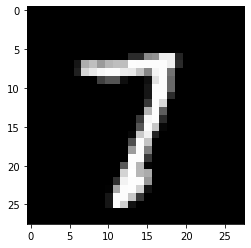

In [24]:
# Plot de uma amostra aleatoria
i = np.random.randint(0, len(X_treinamento))
print(f"Numero: {y_treinamento[i]}")
plt.imshow(X_treinamento[i], cmap='gray');

In [25]:
X_treinamento.shape[0]

6265

In [26]:
# Add mais uma dimensão e formato float32 para uso em RNA 
# (60000, 28, 28, 1)
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [27]:
# Normalizar os dados entre -1 e 1
X_treinamento = (X_treinamento - 127.5) / 127.5

In [28]:
buffer_size = len(X_treinamento)
batch_size = 256 # mini batch gradient descent

In [29]:
# Transformar o dataset em formato do tensorflow
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

# Construção do gerador

O Gerador recebe uma quantidade de números aleatórios e no final vai formar uma imagem

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

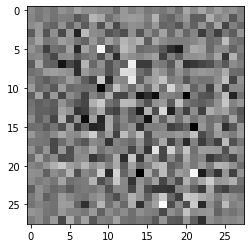

In [30]:

def cria_gerador():
  """Função para receber numeros aleatorios e gerar uma imagem"""
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))  # O uso do Bias = False é porque não estamos fazendo uma classificação de imagem
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256))) # Transformar para padrao do tensorflow

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh')) # Uso da tanh porque nosso dataset de treino é -1 e 1

  network.summary()

  return network






# testar o gerador
gerador = cria_gerador()
ruido = tf.random.normal([1, 100])
imagem_gerada = gerador(ruido, training = False)

# Imagem gerada através de numeros aleatorios 
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

# Construção do discriminador

O objetivo dessa é classficar se a imagem é ou não verdadeira

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [31]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network



discriminador = cria_discriminador()
discriminador(imagem_gerada, training=False) # Classificaçao da imagem é o valor do np

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00276825]], dtype=float32)>

# Cálculo do erro

É preciso calcular o erros do gerador e do discriminador.

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Saida bruta da saida da RN (logits)

def discriminador_loss(expected_output, fake_output):
  """Expected_output são as imagens reais e fake_output imagens falsa"""

  # Saida real é esperado proximo de 1
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)

  # Saida falsa é esperado proximo de 0
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  # Erro
  total_loss = real_loss + fake_loss

  return total_loss

def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Treinamento da GAN e visualização dos resultados

In [33]:
epocas = 100
dimensao_ruido = 100  # Numero aleatorios
numero_imagens = 16  # verificar epoca por epoca

In [34]:
@tf.function
def treinamento(imagens):
  """
  Função para treinamento da GANs
  1 - Gerar as imagens aleatorias baseadas no ruidos
  2 - Depois é enviado para o descriminador que retornara se é real ou fake
  3 - Calcular os erros
  4 - Atualizar os gradientes do treinamento
  """
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  
  # Atualização dos pesos
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training=True)

    expected_output = discriminador(imagens, training=True)
    fake_output = discriminador(imagens_geradas, training=True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [35]:
# Gerar os numeros aleatorios e sera possivel ver as amostras geradas
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])

def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch.shape)
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i, :,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [36]:
treina_gan(X_treinamento, epocas, imagens_teste)

Output hidden; open in https://colab.research.google.com to view.